# Reconocimiento de Dígitos

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 10.1.0
-- The CXX compiler identification is GNU 10.1.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/fyulita/.virtualenvs/scienv/bin/python (found version "3.8.3") 
-- Found PythonLibs: /usr/lib/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/fyulita/Documents/UBA/2020-1C/Metodos Numericos/Material/Laboratorio/tp02
-

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/fyulita/Documents/UBA/2020-1C/Metodos Numericos/Material/Laboratorio/tp02/notebooks
Python 3.8.3


## K-Fold Cross Validation

In [3]:
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
df_train.shape

(42000, 785)

#### Primero usemos parte del conjunto de datos para hacer K-Fold Cross Validation con kNN y kNN+PCA. Luego, en base a los valores optimos que hallemos vamos a hacer kNN en el conjunto entero de datos.

In [4]:
df_train_small = df_train.sample(1000)
df_train_small.shape

(1000, 785)

#### En el primer caracter está el dígito a reconocer. Llamamos a esto y_train.

In [5]:
# Uso values para mandar todo a arrays de numpy
X_train = df_train_small[df_train_small.columns[1:]].values
y_train = df_train_small["label"].values

print(X_train.shape)
print(y_train.shape)

(1000, 784)
(1000,)


#### Veamos una imagen del conjunto de datos.

Supuestamente es un 6


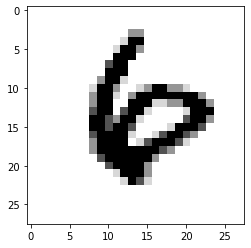

In [6]:
import numpy as np
import matplotlib.pyplot as plt

num = np.random.randint(0, 1000)
print("Supuestamente es un {}".format(int(y_train[num])))

img = X_train[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")

#### ¿Tenemos la misma cantidad de cada número?

In [7]:
df_train["label"].value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

#### No: tenemos más 1 que 5, pero tampoco está tan desbalanceado.

#### Definamos dos funciones, una que haga kNN con cierto k y K-Fold Cross Validation con cierto K y con cierto conjunto de datos y guardemos los tiempos de ejecución y la exactitud; y otra que haga lo mismo pero con PCA. Para evaluar la bondad de los ajustes vamos a utilizar cuatro métricas: la exactitud (o *accuracy*), la kappa de Cohen, el puntaje F1 y el *recall*.

In [8]:
# Dividimos el conjunto de datos en K subconjuntos. Utilizamos K-1 de esos subconjuntos para entrenar y
# usamos el que queda como validacion.

# Se hacen K distintas rondas de entrenamiento variando el subconjunto que se utiliza como validacion. Luego se testea
# cada una de las rondas y se calcula la exactitud promedia entre todas ellas.
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score
from time import time

def kNN_KFold(k, K, X, y):
    # No confundir K de K-fold con k de kNN!!
    kfold = KFold(n_splits=K)
    kfold.get_n_splits(X)
    
    allAcc = []
    allKappa = []
    allF1 = []
    allRecall = []
    kNNTimes = []
    i = 1
    for train_index, test_index in kfold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Inicializamos un nuevo clasificador cada iteracion.
        kNN = metnum.KNNClassifier(k)
        
        kNNTime_start = time()
        # Entreno a la maquina con los K-1 subsets asignados.
        print("Ajustando conjunto de entrenamiento...")
        kNN.fit(X_train, y_train)

        # Ahora hago la prediccion con los X_val que se usan para validar la iteracion de entrenamiento actual.
        print("Prediciendo con el conjunto de test...")
        y_pred = kNN.predict(X_test)
        
        kNNTime_end = time()
        kNNTime = kNNTime_end - kNNTime_start
        kNNTimes.append(kNNTime)
        
        # Comparo las predicciones con los resultados esperados.
        print("Comparando prediccion...")
        acc = accuracy_score(y_test, y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        recall = recall_score(y_test, y_pred, average="macro")
        
        allAcc.append(acc)
        allKappa.append(kappa)
        allF1.append(f1)
        allRecall.append(recall)

        print(f"Ronda {i} terminada\n")
        
        i += 1

    allAcc = np.asarray(allAcc)
    allKappa = np.asarray(allKappa)
    allF1 = np.asarray(allF1)
    allRecall = np.asarray(allRecall)
    kNNTimes = np.asarray(kNNTimes)
    
    meanAcc = np.mean(allAcc)
    meanKappa = np.mean(allKappa)
    meanF1 = np.mean(allF1)
    meanRecall = np.mean(allRecall)
    meanTime = np.mean(kNNTimes)
    
    stdAcc = np.std(allAcc)
    stdKappa = np.std(allKappa)
    stdF1 = np.std(allF1)
    stdRecall = np.std(allRecall)
    stdTime = np.std(kNNTimes)
    
    return [meanAcc, meanKappa, meanF1, meanRecall, meanTime, stdAcc, stdKappa, stdF1, stdRecall, stdTime]

## Estudio de k

#### Veamos cómo el coeficiente k afecta los resultados. Esta celda va a llevar un tiempo en ejecutarse.

In [9]:
%%capture

k_list = np.arange(1, 50)
K = 10

allAccs = []
allKappa = []
allF1 = []
allRecall = []
allTimes = []

for k in k_list:
    ans = kNN_KFold(int(k), K, X_train, y_train)
    
    allAccs.append(ans[0])
    allKappa.append(ans[1])
    allF1.append(ans[2])
    allRecall.append(ans[3])
    allTimes.append(ans[4])

allAccs = np.asarray(allAccs)
allKappa = np.asarray(allKappa)
allF1 = np.asarray(allF1)
allRecall = np.asarray(allRecall)
allTimes = np.asarray(allTimes)

#### Grafiquemos los resultados.

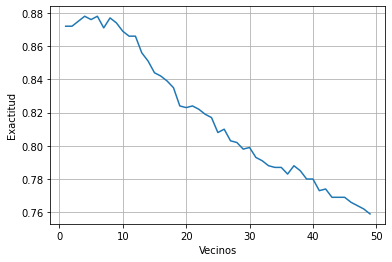

In [10]:
plt.figure("Accs with k")
plt.plot(k_list, allAccs)
plt.grid()
plt.xlabel("Vecinos")
plt.ylabel("Exactitud")
plt.savefig("Imagenes/Accs-with-k.png")
plt.show()

#### Notemos que la exactitud de la predicción decrece a pertir de los 5 vecinos. Esto es raro, ya que uno esperaría que mientras más vecinos haya mejor sería la predicción ya que consideraría más imágenes. Sin embargo, mientras más imágenes consideramos mayor es la proporción de imágenes que no se parecen en nada a la verdadera y mayor es la probabilidad de que, por pura chance, hallan más imágenes distintas a la verdadera en el conjunto de vecinos que igual a la verdadera. De cierta forma esto nos dice que las diferencias entre las clases son altas. Un 1 está muy distinguido de un 8, por ejemplo.

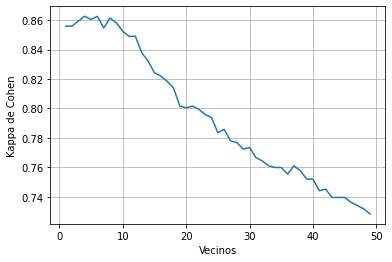

In [11]:
plt.figure("Kappa with k")
plt.plot(k_list, allKappa)
plt.grid()
plt.xlabel("Vecinos")
plt.ylabel("Kappa de Cohen")
plt.savefig("Imagenes/Kappa-with-k.png")
plt.show()

#### Ídem que la exactitud.

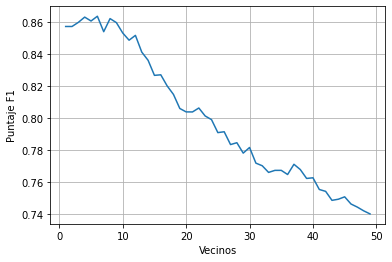

In [12]:
plt.figure("F1 with k")
plt.plot(k_list, allF1)
plt.grid()
plt.xlabel("Vecinos")
plt.ylabel("Puntaje F1")
plt.savefig("Imagenes/F1-with-k.png")
plt.show()

#### Ídem que la exactitud.

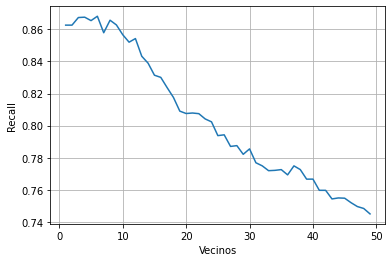

In [15]:
plt.figure("Recall with k")
plt.plot(k_list, allRecall)
plt.grid()
plt.xlabel("Vecinos")
plt.ylabel("Recall")
plt.savefig("Imagenes/Recall-with-k.png")
plt.show()

#### Ídem que la exactitud.

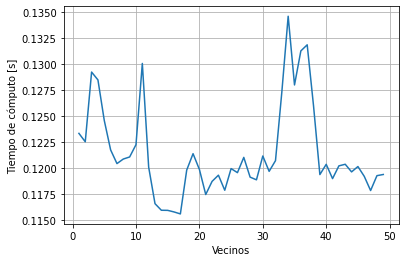

In [14]:
plt.figure("Times with k")
plt.plot(k_list, allTimes)
plt.grid()
plt.xlabel("Vecinos")
plt.ylabel("Tiempo de cómputo [s]")
plt.savefig("Imagenes/Times-with-k.png")
plt.show()

#### Notemos que el tiempo de cómputo se mantiene mas o menos constante. Esto se debe a que si la cantidad de vecinos incrementa la computadora solo tiene que chequear la distancia entre más vecinos, lo cual le lleva más tiempo pero no mucho más.

#### Con este análisis podemos concluir que la mejor cantidad de vecinos es de aproximadamente 3.

In [16]:
print(np.argmax(allAccs))
print(np.argmax(allKappa))
print(np.max(allF1))
print(np.argmax(allRecall))

3
3
0.8637640646016911
5


## Estudio de \\( \alpha \\)

#### Veamos cómo el coeficiente \\( \alpha \\) afecta los resultados. Esta celda va a llevar un tiempo en ejecutarse.

In [17]:
%%capture

k = 3
K = 10
alpha_list = np.arange(1, 100)

allAccs = []
allKappa = []
allF1 = []
allRecall = []
allkNNTimes = []
allPCATimes = []

for alpha in alpha_list:
    PCATime_start = time()
    pca = metnum.PCA(int(alpha))
    pca.fit(X_train)
    X_trans = pca.transform(X_train)
    PCATime_end = time()
    PCATime = PCATime_end - PCATime_start
    allPCATimes.append(PCATime)
    
    ans = kNN_KFold(k, K, X_trans, y_train)
    
    allAccs.append(ans[0])
    allKappa.append(ans[1])
    allF1.append(ans[2])
    allRecall.append(ans[3])
    allkNNTimes.append(ans[4])

allAccs = np.asarray(allAccs)
allKappa = np.asarray(allKappa)
allF1 = np.asarray(allF1)
allRecall = np.asarray(allRecall)
allkNNTimes = np.asarray(allkNNTimes)
allPCATimes = np.asarray(allPCATimes)

#### Grafiquemos los resultados.

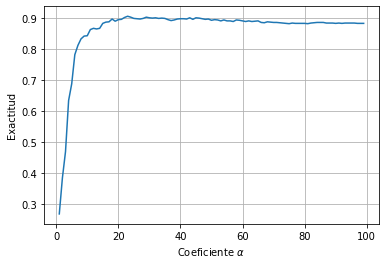

In [18]:
plt.figure("Accs with alpha")
plt.plot(alpha_list, allAccs)
plt.grid()
plt.xlabel(r"Coeficiente $\alpha$")
plt.ylabel("Exactitud")
plt.savefig("Imagenes/Accs-with-alpha.png")
plt.show()

#### Notemos que la exactitud incrementa. Esto es razonable, ya que a medida que \\( \alpha \\) incrementa estamos tomando más dimensiones relevantes del sistema. Sin embargo, notemos que a partir de \\( \alpha \\) = 20 la exactitud es mas o menos constante. Esto se debe a que las nuevas dimensiones son cada vez menos relevantes. 

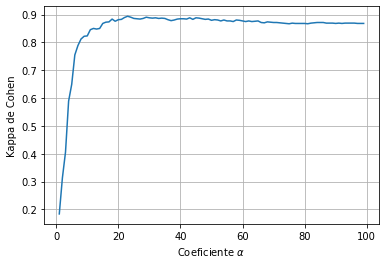

In [19]:
plt.figure("Kappa with alpha")
plt.plot(alpha_list, allKappa)
plt.grid()
plt.xlabel(r"Coeficiente $\alpha$")
plt.ylabel("Kappa de Cohen")
plt.savefig("Imagenes/Kappa-with-alpha.png")
plt.show()

#### Ídem que la exactitud.

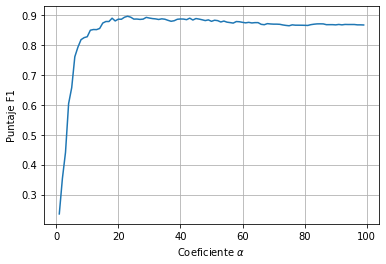

In [20]:
plt.figure("F1 with alpha")
plt.plot(alpha_list, allF1)
plt.grid()
plt.xlabel(r"Coeficiente $\alpha$")
plt.ylabel("Puntaje F1")
plt.savefig("Imagenes/F1-with-alpha.png")
plt.show()

#### Ídem que la exactitud.

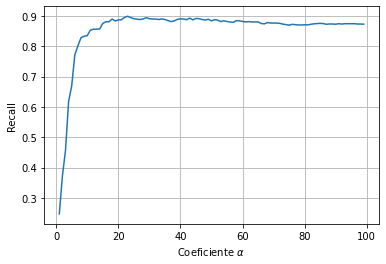

In [21]:
plt.figure("Recall with alpha")
plt.plot(alpha_list, allRecall)
plt.grid()
plt.xlabel(r"Coeficiente $\alpha$")
plt.ylabel("Recall")
plt.savefig("Imagenes/Recall-with-alpha.png")
plt.show()

#### Ídem que la exactitud.

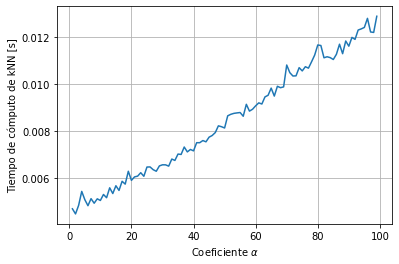

In [22]:
plt.figure("kNNTimes with alpha")
plt.plot(alpha_list, allkNNTimes)
plt.grid()
plt.xlabel(r"Coeficiente $\alpha$")
plt.ylabel("Tiempo de cómputo de kNN [s]")
plt.savefig("Imagenes/kNNTimes-with-alpha.png")
plt.show()

#### Notemos que el tiempo de cómputo de kNN incrementa linealmente.

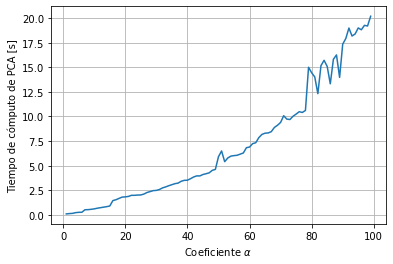

In [23]:
plt.figure("PCATimes with alpha")
plt.plot(alpha_list, allPCATimes)
plt.grid()
plt.xlabel(r"Coeficiente $\alpha$")
plt.ylabel("Tiempo de cómputo de PCA [s]")
plt.savefig("Imagenes/PCATimes-with-alpha.png")
plt.show()

#### Notemos que el tiempo de cómputo de PCA incrementa. Esto es esperable, ya que cada vez hay que calcular más autovalores. Debido a que el tiempo de cómputo de los primeros autovalores es menor al tiempo de cómputo de los últimos autovalores el gráfico incrementa cada vez más rápidamente.

#### Con este análisis podemos concluir que el mejor valor de \\( \alpha \\) es de aproximadamente 20.

## Estudio de K

#### Veamos cómo el coeficiente K afecta los resultados. Esta celda va a llevar un tiempo en ejecutarse.

In [24]:
%%capture

k = 3
K_list = np.arange(2, 50)

allAccs = []
allKappa = []
allF1 = []
allRecall = []
allTimes = []

for K in K_list:
    ans = kNN_KFold(k, int(K), X_train, y_train)
    
    allAccs.append(ans[0])
    allKappa.append(ans[1])
    allF1.append(ans[2])
    allRecall.append(ans[3])
    allTimes.append(ans[4])

allAccs = np.asarray(allAccs)
allKappa = np.asarray(allKappa)
allF1 = np.asarray(allF1)
allRecall = np.asarray(allRecall)
allTimes = np.asarray(allTimes)

#### Grafiquemos los resultados.

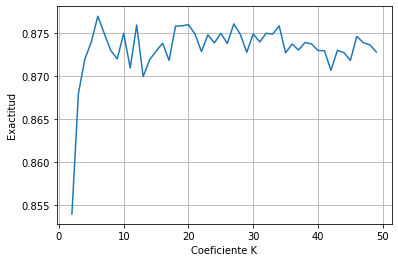

In [25]:
plt.figure("Accs with K")
plt.plot(K_list, allAccs)
plt.grid()
plt.xlabel(r"Coeficiente K")
plt.ylabel("Exactitud")
plt.savefig("Imagenes/Accs-with-K.png")
plt.show()

#### Notemos que la exactitud incrementa, lo cual es razonable ya que el conjunto de entrenamiento es más grande para mayores valores de K. Sin embargo, el conjunto de entrenamiento cada vez crece menos y podemos ver que a partir de K = 20 la exactitud no crece mucho más.

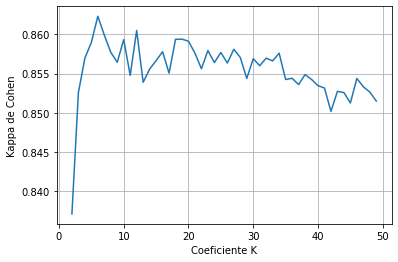

In [27]:
plt.figure("Kappa with K")
plt.plot(K_list, allKappa)
plt.grid()
plt.xlabel(r"Coeficiente K")
plt.ylabel("Kappa de Cohen")
plt.savefig("Imagenes/Kappa-with-K.png")
plt.show()

#### Ídem que la exactitud.

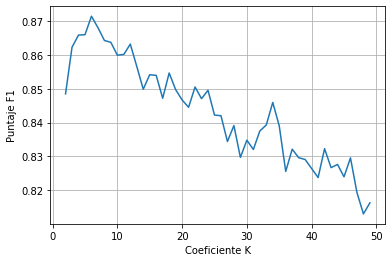

In [28]:
plt.figure("F1 with K")
plt.plot(K_list, allF1)
plt.grid()
plt.xlabel(r"Coeficiente K")
plt.ylabel("Puntaje F1")
plt.savefig("Imagenes/F1-with-K.png")
plt.show()

#### Notemos que parece haber un máximo cerca de K = 10 y K = 15.

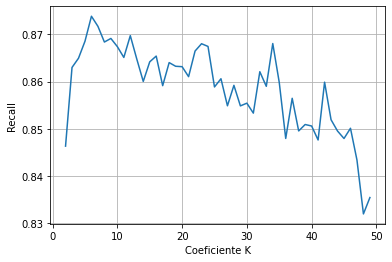

In [29]:
plt.figure("Recall with K")
plt.plot(K_list, allRecall)
plt.grid()
plt.xlabel(r"Coeficiente K")
plt.ylabel("Recall")
plt.savefig("Imagenes/Recall-with-K.png")
plt.show()

#### Ídem que el puntaje F1.

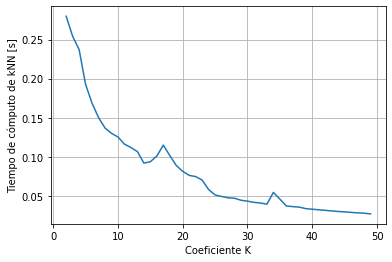

In [30]:
plt.figure("Times with K")
plt.plot(K_list, allTimes)
plt.grid()
plt.xlabel(r"Coeficiente K")
plt.ylabel("Tiempo de cómputo de kNN [s]")
plt.savefig("Imagenes/Times-with-K.png")
plt.show()

#### Notemos que el tiempo de cómpute de kNN decrece. Esto sucede porque cada vez hay que ajustar menos valores porque el conjunto de test es más pequeño. Sin embargo, el tiempo de cómputo total incrementa ya que cada vez hay más rondas.

#### Con este análisis podemos concluir que el mejor valor de K es de aproximadamente 10.

## Estudio de tamaño sin PCA

In [31]:
%%capture

sizes = np.linspace(100, 5000, 100)
k = 3
K = 10

allAccs = []
allKappa = []
allF1 = []
allRecall = []
allTimes = []

for size in sizes:
    df_size = df_train.sample(int(size))
    X_size = df_size[df_size.columns[1:]].values
    y_size = df_size["label"].values
    
    ans = kNN_KFold(k, K, X_size, y_size)
    
    allAccs.append(ans[0])
    allKappa.append(ans[1])
    allF1.append(ans[2])
    allRecall.append(ans[3])
    allTimes.append(ans[4])

allAccs = np.asarray(allAccs)
allKappa = np.asarray(allKappa)
allF1 = np.asarray(allF1)
allRecall = np.asarray(allRecall)
allTimes = np.asarray(allTimes)

#### Grafiquemos los resultados.

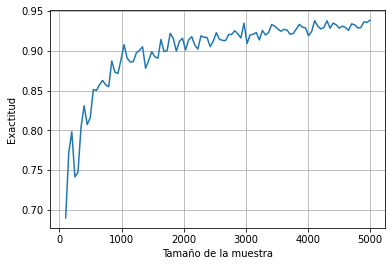

In [32]:
plt.figure("Accs with size no pca")
plt.plot(sizes, allAccs)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Exactitud")
plt.savefig("Imagenes/Accs-with-size-no-PCA.png")
plt.show()

#### Notemos que la exactitud incrementa. Esto es una buena señal, ya que los parámetros utilizados son los óptimos para la muestra de 1000 datos, pero acá vemos que esos mismos parámetros funcionan aún mejor para muestras más grandes. Esto no nos asegura que estos parámetros sean los óptimos para cualquier tamaño de muestra pero al menos nos asegura que el tamaño no va a hacer que la exactitud decrezca.

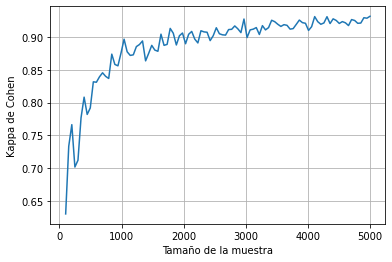

In [33]:
plt.figure("Kappa with size no pca")
plt.plot(sizes, allKappa)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Kappa de Cohen")
plt.savefig("Imagenes/Kappa-with-size-no-PCA.png")
plt.show()

#### Ídem que la exactitud.

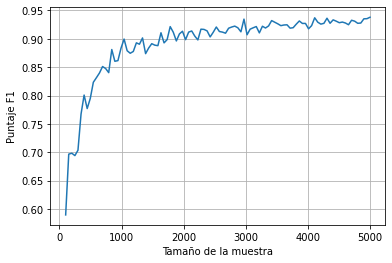

In [34]:
plt.figure("F1 with size no pca")
plt.plot(sizes, allF1)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Puntaje F1")
plt.savefig("Imagenes/F1-with-size-no-PCA.png")
plt.show()

#### Ídem que la exactitud.

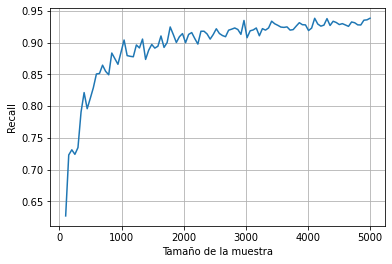

In [35]:
plt.figure("Recall with size no pca")
plt.plot(sizes, allRecall)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Recall")
plt.savefig("Imagenes/Recall-with-size-no-PCA.png")
plt.show()

#### Ídem que la exactitud.

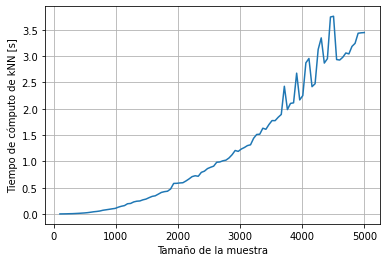

In [36]:
plt.figure("Times with size no pca")
plt.plot(sizes, allTimes)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Tiempo de cómputo de kNN [s]")
plt.savefig("Imagenes/Times-with-size-no-PCA.png")
plt.show()

#### Notemos que el tiempo de cómputo de kNN incrementa. Esto es esperable, ya que cada vez debe ajustar más imágenes.

## Estudio del tamaño con PCA

#### Veamos cómo el tamaño de la muestra utilizada afecta los resultados si usamos PCA.

In [37]:
%%capture

sizes = np.linspace(100, 5000, 100)
k = 3
K = 10
alpha = 20

allAccs = []
allKappa = []
allF1 = []
allRecall = []
allkNNTimes = []
allPCATimes = []

for size in sizes:
    df_size = df_train.sample(int(size))
    X_size = df_size[df_size.columns[1:]].values
    y_size = df_size["label"].values
    
    PCATime_start = time()
    pca = metnum.PCA(alpha)
    pca.fit(X_size)
    X_trans = pca.transform(X_size)
    PCATime_end = time()
    PCATime = PCATime_end - PCATime_start
    allPCATimes.append(PCATime)
    
    ans = kNN_KFold(k, K, X_trans, y_size)
    
    allAccs.append(ans[0])
    allKappa.append(ans[1])
    allF1.append(ans[2])
    allRecall.append(ans[3])
    allkNNTimes.append(ans[4])

allAccs = np.asarray(allAccs)
allKappa = np.asarray(allKappa)
allF1 = np.asarray(allF1)
allRecall = np.asarray(allRecall)
allkNNTimes = np.asarray(allkNNTimes)
allPCATimes = np.asarray(allPCATimes)

#### Grafiquemos los resultados.

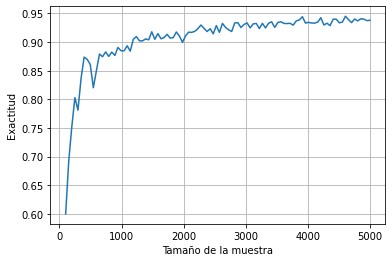

In [38]:
plt.figure("Accs with size with PCA")
plt.plot(sizes, allAccs)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Exactitud")
plt.savefig("Imagenes/Accs-with-size-with-PCA.png")
plt.show()

#### Notemos que la exactitud incrementa. Esto es una buena señal, ya que los parámetros utilizados son los óptimos para la muestra de 1000 datos, pero acá vemos que esos mismos parámetros funcionan aún mejor para muestras más grandes. Esto no nos asegura que estos parámetros sean los óptimos para cualquier tamaño de muestra pero al menos nos asegura que el tamaño no va a hacer que la exactitud decrezca.

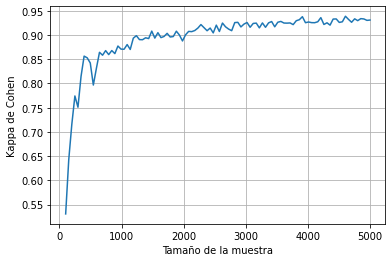

In [39]:
plt.figure("Kappa with size with PCA")
plt.plot(sizes, allKappa)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Kappa de Cohen")
plt.savefig("Imagenes/Kappa-with-size-with-PCA.png")
plt.show()

#### Ídem que la exactitud.

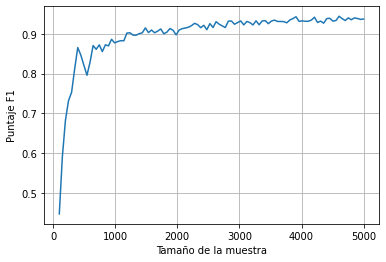

In [40]:
plt.figure("F1 with size with PCA")
plt.plot(sizes, allF1)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Puntaje F1")
plt.savefig("Imagenes/F1-with-size-with-PCA.png")
plt.show()

#### Ídem que la exactitud.

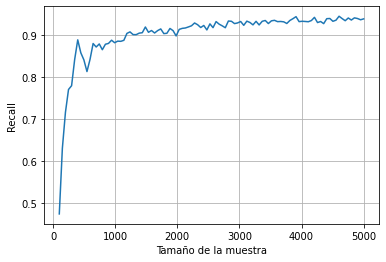

In [41]:
plt.figure("Recall with size with PCA")
plt.plot(sizes, allRecall)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Recall")
plt.savefig("Imagenes/Recall-with-size-with-PCA.png")
plt.show()

#### Ídem que la exactitud.

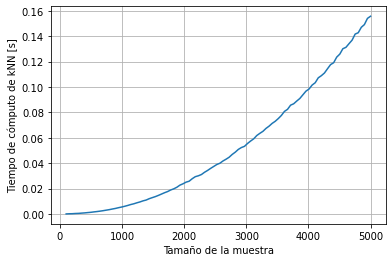

In [42]:
plt.figure("kNNTimes with size with PCA")
plt.plot(sizes, allkNNTimes)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Tiempo de cómputo de kNN [s]")
plt.savefig("Imagenes/kNNTimes-with-size-with-PCA.png")
plt.show()

#### Notemos que el tiempo de cómputo de kNN incrementa. Esto es esperable, ya que cada vez debe ajustar más imágenes.

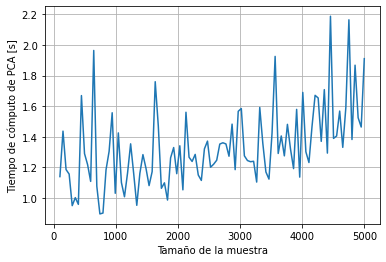

In [43]:
plt.figure("PCATimes with size with PCA")
plt.plot(sizes, allPCATimes)
plt.grid()
plt.xlabel(r"Tamaño de la muestra")
plt.ylabel("Tiempo de cómputo de PCA [s]")
plt.savefig("Imagenes/PCATimes-with-size-with-PCA.png")
plt.show()

#### Notemos que el tiempo de cómputo de PCA es muy ruidoso. Esto es esperable, ya que el tamaño de la muestra sólo afecta al cálculo de covarianza pero no al cálculo de autovalores ya que los limitamos a \\( \alpha \\) = 20 autovalores.

## kNN sin PCA

#### Tomemos el conjunto completo de datos y hagamos kNN sin PCA usando los coeficientes óptimos que calculamos.

In [42]:
X_train = df_train[df_train.columns[1:]].values
y_train = df_train["label"].values

print(X_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


In [43]:
%%time

k = 3
K = 10
[acc_kNN, kappa_kNN, f1_kNN, recall_kNN, time_kNN, acc_std_kNN, kappa_std_kNN, f1_std_kNN, recall_std_kNN, time_std_kNN] = kNN_KFold(k, K, X_train, y_train)

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 1 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 2 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 3 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 4 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 5 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 6 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 7 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 8 terminada

Ajustando conjunto de en

## kNN con PCA

#### Tomemos el conjunto completo de datos y hagamos kNN sin PCA usando los coeficientes óptimos que calculamos.

In [44]:
%%time

k = 3
K = 10
alpha = 20

pcaTime_start = time()
pca = metnum.PCA(alpha)
pca.fit(X_train)
X_trans = pca.transform(X_train)
pcaTime_end = time()
pcaTime = pcaTime_end - pcaTime_start

[acc_PCA, kappa_PCA, f1_PCA, recall_PCA, time_PCA, acc_std_PCA, kappa_std_PCA, f1_std_PCA, recall_std_PCA, time_std_PCA] = kNN_KFold(k, K, X_trans, y_train)

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 1 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 2 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 3 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 4 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 5 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 6 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 7 terminada

Ajustando conjunto de entrenamiento...
Prediciendo con el conjunto de test...
Comparando prediccion...
Ronda 8 terminada

Ajustando conjunto de en

In [45]:
print([acc_kNN, kappa_kNN, f1_kNN, recall_kNN, time_kNN, acc_std_kNN, kappa_std_kNN, f1_std_kNN, recall_std_kNN, time_std_kNN])
print([acc_PCA, kappa_PCA, f1_PCA, recall_PCA, time_PCA, acc_std_PCA, kappa_std_PCA, f1_std_PCA, recall_std_PCA, time_std_PCA])
print(pcaTime)

[0.9695, 0.9660920329627973, 0.9692713395710504, 0.9690323375205139, 881.9351910829544, 0.0027509017280630582, 0.00305437665273647, 0.002720726738553207, 0.002678535420181038, 32.17578012899067]
[0.969404761904762, 0.9659881775885617, 0.9691705765728568, 0.9691518644492273, 16.359651613235474, 0.0031429473291533405, 0.0034915603257843937, 0.0030087294694638627, 0.0029421698257952283, 0.042800922820084464]
5.565018892288208


#### Notemos que las métricas de bondad de ajuste de ambos algoritmos son prácticamente las mismas mientras que el tiempo de cómputo de kNN con PCA es un órden de magnitud menor que el tiempo de cómputo de kNN sin PCA.